<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/main/models/base_models_STHyMOUNTAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Entrenamiento de Modelos Baseline para Predicción Espaciotemporal de Precipitación Mensual STHyMOUNTAIN

Este notebook implementa modelos baseline para la predicción de precipitaciones usando datos espaciotemporales.

## 🔍 Implementación de Modelos Avanzados y Técnicas de Validación

Además de los modelos tabulares baseline, implementaremos:

1. **Optimización avanzada con Optuna** para los modelos tabulares XGBoost y LightGBM
2. **Validación robusta** mediante:
   - Hold-Out Validation (ya implementada)
   - Cross-Validation (k=5)
   - Bootstrapping (100 muestras)
3. **Modelos de Deep Learning** para capturar patrones espaciales y temporales:
   - Redes CNN para patrones espaciales
   - Redes ConvLSTM para patrones espaciotemporales

El objetivo es proporcionar una evaluación completa de diferentes enfoques de modelado para la predicción de precipitación en regiones montañosas.

In [11]:
# Configuración del entorno (compatible con Colab y local)
import os
import sys
from pathlib import Path
import shutil

# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')   
    # Si estamos en Colab, clonar el repositorio
    !git clone https://github.com/ninja-marduk/ml_precipitation_prediction.git
    %cd ml_precipitation_prediction
    # Instalar dependencias necesarias
    !pip install -r requirements.txt
    !pip install xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn
    BASE_PATH = '/content/drive/MyDrive/ml_precipitation_prediction'
else:
    # Si estamos en local, usar la ruta actual
    if '/models' in os.getcwd():
        BASE_PATH = Path('..')
    else:
        BASE_PATH = Path('.')

print(f"Entorno configurado. Usando ruta base: {BASE_PATH}")

# Si BASE_PATH viene como string, lo convertimos
BASE_PATH = Path(BASE_PATH)

# Ahora puedes concatenar correctamente
model_output_dir = BASE_PATH / 'models' / 'output'
model_output_dir.mkdir(parents=True, exist_ok=True)

print(f"Directorio para salida de modelos creado: {model_output_dir}")

# Implementación de resiliencia para interacción con Google Drive y restauración de datos
def backup_dataframe(df, backup_path):
    """Guarda un DataFrame como respaldo en formato Parquet."""
    try:
        df.to_parquet(backup_path, index=False)
        print(f"Respaldo del DataFrame guardado en: {backup_path}")
    except Exception as e:
        print(f"Error al guardar respaldo del DataFrame: {e}")

def restore_dataframe(backup_path):
    """Restaura un DataFrame desde un archivo de respaldo en formato Parquet."""
    try:
        if backup_path.exists():
            df_restored = pd.read_parquet(backup_path)
            print(f"DataFrame restaurado desde: {backup_path}")
            return df_restored
        else:
            print(f"No se encontró el archivo de respaldo en: {backup_path}")
            return None
    except Exception as e:
        print(f"Error al restaurar el DataFrame: {e}")
        return None

# Ruta para respaldo temporal del DataFrame
temp_dir = BASE_PATH / 'data' / 'output' / 'temp'
temp_dir.mkdir(parents=True, exist_ok=True)
temp_file_path = temp_dir / 'dataframe_backup.parquet'

# Respaldo inicial del DataFrame principal
if 'df' in locals() and df is not None:
    backup_dataframe(df, temp_file_path)

# Modificar interacción con Google Drive para reintentos
max_retries = 3
retry_delay = 5  # segundos

def mount_google_drive():
    """Intenta montar Google Drive con reintentos."""
    for attempt in range(max_retries):
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("Google Drive montado exitosamente.")
            return True
        except Exception as e:
            print(f"Error al montar Google Drive (intento {attempt + 1}/{max_retries}): {e}")
            if attempt < max_retries - 1:
                time.sleep(retry_delay)
    print("No se pudo montar Google Drive después de varios intentos.")
    return False

if IN_COLAB:
    if not mount_google_drive():
        print("Usando datos en memoria o restaurando desde respaldo local.")
        df = restore_dataframe(temp_file_path)

# Restaurar modelos guardados en caso de fallo
model_files = {
    'RandomForest': model_output_dir / 'RandomForest.pkl',
    'XGBoost': model_output_dir / 'XGBoost.pkl',
    'LightGBM': model_output_dir / 'LightGBM.pkl'
}

def load_saved_model(model_name, model_path):
    """Carga un modelo guardado desde disco."""
    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
            print(f"Modelo {model_name} cargado desde: {model_path}")
            return model
    except Exception as e:
        print(f"Error al cargar el modelo {model_name}: {e}")
        return None

# Inicializar `modelos_base` como un diccionario vacío
modelos_base = {}

# Intentar cargar modelos guardados
for model_name, model_path in model_files.items():
    if model_name not in modelos_base:
        modelos_base[model_name] = load_saved_model(model_name, model_path)

# Implementación de resiliencia para modelos CNN y ConvLSTM

# Respaldo y restauración de modelos CNN y ConvLSTM
cnn_model_path = model_output_dir / 'cnn_model.h5'
convlstm_model_path = model_output_dir / 'convlstm_model.h5'

def backup_model(model, model_path):
    """Guarda un modelo de Keras como respaldo."""
    try:
        model.save(model_path)
        print(f"Modelo respaldado en: {model_path}")
    except Exception as e:
        print(f"Error al guardar respaldo del modelo: {e}")

def restore_model(model_path):
    """Restaura un modelo de Keras desde un archivo de respaldo."""
    try:
        if model_path.exists():
            model = tf.keras.models.load_model(model_path)
            print(f"Modelo restaurado desde: {model_path}")
            return model
        else:
            print(f"No se encontró el archivo de respaldo en: {model_path}")
            return None
    except Exception as e:
        print(f"Error al restaurar el modelo: {e}")
        return None

# Respaldo inicial de modelos si existen
if 'cnn_model' in locals() and cnn_model is not None:
    backup_model(cnn_model, cnn_model_path)
if 'convlstm_model' in locals() and convlstm_model is not None:
    backup_model(convlstm_model, convlstm_model_path)

# Restaurar modelos en caso de fallo
if 'cnn_model' not in locals() or cnn_model is None:
    cnn_model = restore_model(cnn_model_path)
if 'convlstm_model' not in locals() or convlstm_model is None:
    convlstm_model = restore_model(convlstm_model_path)

# Modificar interacción con Google Drive para reintentos
max_retries = 3
retry_delay = 5  # segundos

def mount_google_drive():
    """Intenta montar Google Drive con reintentos."""
    for attempt in range(max_retries):
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("Google Drive montado exitosamente.")
            return True
        except Exception as e:
            print(f"Error al montar Google Drive (intento {attempt + 1}/{max_retries}): {e}")
            if attempt < max_retries - 1:
                time.sleep(retry_delay)
    print("No se pudo montar Google Drive después de varios intentos.")
    return False

if IN_COLAB:
    if not mount_google_drive():
        print("Usando datos en memoria o restaurando desde respaldo local para modelos CNN y ConvLSTM.")

Entorno configurado. Usando ruta base: ..
Directorio para salida de modelos creado: ../models/output
Respaldo del DataFrame guardado en: ../data/output/temp/dataframe_backup.parquet
Respaldo del DataFrame guardado en: ../data/output/temp/dataframe_backup.parquet
Modelo RandomForest cargado desde: ../models/output/RandomForest.pkl
Modelo XGBoost cargado desde: ../models/output/XGBoost.pkl
Modelo LightGBM cargado desde: ../models/output/LightGBM.pkl
No se encontró el archivo de respaldo en: ../models/output/cnn_model.h5
No se encontró el archivo de respaldo en: ../models/output/convlstm_model.h5
Modelo RandomForest cargado desde: ../models/output/RandomForest.pkl
Modelo XGBoost cargado desde: ../models/output/XGBoost.pkl
Modelo LightGBM cargado desde: ../models/output/LightGBM.pkl
No se encontró el archivo de respaldo en: ../models/output/cnn_model.h5
No se encontró el archivo de respaldo en: ../models/output/convlstm_model.h5


In [12]:
# 1. Importaciones necesarias
import numpy as np
import pandas as pd
import xarray as xr
import optuna
import pickle
import datetime
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Importaciones para barras de progreso y mejora de visualización
from tqdm.notebook import tqdm, trange
from IPython.display import display, HTML, clear_output
import time

# Configurar visualización más atractiva
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [13]:
# Importaciones adicionales para Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, Conv3D, ConvLSTM2D, BatchNormalization, 
                                   MaxPooling2D, Flatten, Input, concatenate, Reshape, TimeDistributed, UpSampling2D)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

print("TensorFlow versión:", tf.__version__)

# Configurar GPU si está disponible
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"GPU disponible: {physical_devices}")
    # Permitir crecimiento de memoria según sea necesario
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("No se detectó GPU. Usando CPU.")

TensorFlow versión: 2.18.0
No se detectó GPU. Usando CPU.


In [14]:
# 2. Cargar el dataset NetCDF
def load_dataset(file_path):
    """Carga un archivo NetCDF y lo convierte a pandas DataFrame"""
    try:
        # Cargar el archivo NetCDF con xarray
        print(f"Intentando cargar el archivo: {file_path}")
        ds = xr.open_dataset(file_path)
        print("Archivo cargado exitosamente con xarray")

        # Mostrar información del dataset cargado
        print("\nInformación del dataset:")
        print(ds.info())
        print("\nVariables disponibles:")
        for var_name in ds.data_vars:
            print(f"- {var_name}: {ds[var_name].shape}")

        # Convertir a DataFrame
        df = ds.to_dataframe().reset_index()
        return df, ds
    except Exception as e:
        print(f"Error al cargar el archivo NetCDF: {e}")
        return None, None

# Ruta al dataset
data_file = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features.nc'
print(f"Buscando archivo en: {data_file}")

# Cargar el dataset
df, ds_original = load_dataset(data_file)

# Verificar si se cargó correctamente
if df is not None:
    print(f"Dataset cargado con éxito. Dimensiones: {df.shape}")
    print("\nPrimeras filas del DataFrame:")
    display(df.head())
else:
    print("No se pudo cargar el dataset. Verificar la ruta y el formato del archivo.")

Buscando archivo en: ../data/output/complete_dataset_with_features.nc
Intentando cargar el archivo: ../data/output/complete_dataset_with_features.nc
Archivo cargado exitosamente con xarray

Información del dataset:
xarray.Dataset {
dimensions:
	time = 530 ;
	latitude = 62 ;
	longitude = 66 ;

variables:
	datetime64[ns] time(time) ;
	float32 latitude(latitude) ;
	float32 longitude(longitude) ;
	float32 total_precipitation(time, latitude, longitude) ;
	float32 max_daily_precipitation(time, latitude, longitude) ;
	float32 min_daily_precipitation(time, latitude, longitude) ;
	float32 daily_precipitation_std(time, latitude, longitude) ;
	float32 month_sin(time, latitude, longitude) ;
	float32 month_cos(time, latitude, longitude) ;
	float32 doy_sin(time, latitude, longitude) ;
	float32 doy_cos(time, latitude, longitude) ;
	float64 elevation(latitude, longitude) ;
	float32 slope(latitude, longitude) ;
	float32 aspect(latitude, longitude) ;

// global attributes:
	:description = ST-HyMOUNTAIN-

,time,latitude,longitude,total_precipitation,max_daily_precipitation,min_daily_precipitation,daily_precipitation_std,month_sin,month_cos,doy_sin,doy_cos,elevation,slope,aspect
0,1981-01-01,4.324997,-74.975006,47.381050,24.706928,0.0,5.825776,0.5,0.866025,0.017202,0.999852,493.784552,89.539551,102.044502
1,1981-01-01,4.324997,-74.925003,40.750824,21.819195,0.0,5.019045,0.5,0.866025,0.017202,0.999852,519.750107,89.867020,73.481674
2,1981-01-01,4.324997,-74.875008,46.338623,26.092327,0.0,5.740223,0.5,0.866025,0.017202,0.999852,248.776045,89.722221,65.916817
3,1981-01-01,4.324997,-74.825005,48.779938,29.421450,0.0,5.611738,0.5,0.866025,0.017202,0.999852,351.415728,86.986130,140.916000
4,1981-01-01,4.324997,-74.775002,38.932945,18.483061,0.0,3.733574,0.5,0.866025,0.017202,0.999852,278.261922,88.273293,18.439939


In [15]:
# 3. Preparación de los datos
if df is not None:
    # Identificar la columna objetivo (precipitación)
    target_column = 'total_precipitation'  # Ajustar si tiene otro nombre en tu dataset

    # Ver si existe 'precip_target' o usar 'total_precipitation'
    if 'total_precipitation' in df.columns:
        target_column = 'total_precipitation'

    print(f"Columna objetivo identificada: {target_column}")

    # Separar variables predictoras y variable objetivo
    feature_cols = [col for col in df.columns if col != target_column and not pd.isna(df[col]).all()]

    # Eliminar columnas no numéricas para los modelos (como fechas o coordenadas si no se usan como features)
    non_feature_cols = ['time', 'spatial_ref']
    feature_cols = [col for col in feature_cols if col not in non_feature_cols]

    # Eliminar filas con valores NaN
    print(f"Filas antes de eliminar NaN: {df.shape[0]}")
    df_clean = df.dropna(subset=[target_column] + feature_cols)
    print(f"Filas después de eliminar NaN: {df_clean.shape[0]}")

    # Separar features y target
    X = df_clean[feature_cols]
    y = df_clean[target_column]

    print(f"\nFeatures seleccionadas ({len(feature_cols)}):\n{feature_cols}")
    print(f"\nVariable objetivo: {target_column}")

Columna objetivo identificada: total_precipitation
Filas antes de eliminar NaN: 2168760
Filas después de eliminar NaN: 2168760

Features seleccionadas (12):
['latitude', 'longitude', 'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'elevation', 'slope', 'aspect']

Variable objetivo: total_precipitation

Features seleccionadas (12):
['latitude', 'longitude', 'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'elevation', 'slope', 'aspect']

Variable objetivo: total_precipitation


In [16]:
# 4. División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensiones del conjunto de entrenamiento: {X_train.shape}")
print(f"Dimensiones del conjunto de prueba: {X_test.shape}")

# 5. Estandarización de variables predictoras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Guardar el scaler para uso futuro
with open(model_output_dir / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Escalador guardado en models/output/scaler.pkl")

Dimensiones del conjunto de entrenamiento: (1735008, 12)
Dimensiones del conjunto de prueba: (433752, 12)
Escalador guardado en models/output/scaler.pkl


In [17]:
# 6. Funciones de evaluación y entrenamiento
def evaluar_modelo(y_true, y_pred):
    """Evalúa el rendimiento de un modelo usando múltiples métricas"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

def entrenar_y_evaluar_modelo(modelo, nombre, X_train, y_train, X_test, y_test):
    """Entrena un modelo y evalúa su rendimiento con visualización del progreso"""
    # Crear widget para mostrar información del proceso
    display(HTML(f'<div style="background-color:#f0f8ff; padding:10px; border-radius:5px;">' +
                 f'<h3>🔄 Entrenando modelo: {nombre}</h3>' +
                 f'<div id="status_{nombre}">Estado: Iniciando entrenamiento...</div>' +
                 f'</div>'))
    
    # Tiempo de inicio
    start_time = time.time()
    
    # Entrenar el modelo con seguimiento visual según el tipo
    if hasattr(modelo, 'fit_generator') or nombre in ['XGBoost', 'XGBoost_Optuna', 'LightGBM', 'LightGBM_Optuna']:
        # Para modelos que soportan entrenamiento por lotes como XGBoost, LightGBM
        print(f"Entrenando {nombre} con visualización de progreso...")
        if hasattr(modelo, 'n_estimators'):
            n_estimators = modelo.n_estimators
            for i in tqdm(range(n_estimators), desc=f"Entrenando {nombre}"):
                if i == 0:
                    # Primera iteración, ajuste inicial
                    if nombre.startswith('LightGBM'):
                        # LightGBM tiene parámetro verbose
                        temp_modelo = type(modelo)(n_estimators=1, **{k:v for k,v in modelo.get_params().items() 
                                                                 if k != 'n_estimators' and k != 'verbose'}, verbose=-1)
                    else:
                        temp_modelo = type(modelo)(n_estimators=1, **{k:v for k,v in modelo.get_params().items() 
                                                                if k != 'n_estimators'})
                    temp_modelo.fit(X_train, y_train)
                elif i == n_estimators - 1:
                    # Última iteración, ajuste completo
                    modelo.fit(X_train, y_train)
                
                # Actualizar progreso visual
                if i % max(1, n_estimators // 10) == 0:
                    clear_output(wait=True)
                    display(HTML(f'<div style="background-color:#f0f8ff; padding:10px; border-radius:5px;">' +
                                f'<h3>🔄 Entrenando modelo: {nombre}</h3>' +
                                f'<div id="status_{nombre}">Estado: Progreso {i+1}/{n_estimators} estimadores ({((i+1)/n_estimators*100):.1f}%)</div>' +
                                f'</div>'))
                    time.sleep(0.1)  # Pequeña pausa para actualización visual
        else:
            # Si no tiene n_estimators, entrenamiento directo
            modelo.fit(X_train, y_train)
    else:
        # Para modelos estándar como RandomForest
        modelo.fit(X_train, y_train)
    
    # Tiempo de entrenamiento
    training_time = time.time() - start_time
    
    # Visualizar tiempo de entrenamiento
    display(HTML(f'<div style="background-color:#e6ffe6; padding:10px; border-radius:5px;">' +
                f'<h3>✅ Entrenamiento completado: {nombre}</h3>' +
                f'<div>Tiempo de entrenamiento: {training_time:.2f} segundos</div>' +
                f'</div>'))
    
    print(f"Evaluando rendimiento de {nombre}...")
    predicciones = modelo.predict(X_test)
    rmse, mae, r2 = evaluar_modelo(y_test, predicciones)
    
    # Visualizar métricas con estilo
    display(HTML(f'<div style="background-color:#f5f5dc; padding:10px; border-radius:5px; margin-top:10px;">' +
                f'<h3>📊 Métricas para {nombre}</h3>' +
                f'<table style="width:100%; text-align:left;">' +
                f'<tr><th>Métrica</th><th>Valor</th></tr>' +
                f'<tr><td>RMSE</td><td>{rmse:.4f}</td></tr>' +
                f'<tr><td>MAE</td><td>{mae:.4f}</td></tr>' +
                f'<tr><td>R²</td><td>{r2:.4f}</td></tr>' +
                f'</table></div>'))
    
    return modelo, (rmse, mae, r2)

def guardar_modelo(modelo, nombre):
    """Guarda un modelo entrenado en disco"""
    # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    # filename = f"{nombre}_{timestamp}.pkl"
    filename = f"{nombre}.pkl"
    with open(model_output_dir / filename, 'wb') as f:
        pickle.dump(modelo, f)
    
    # Visualizar confirmación de guardado
    display(HTML(f'<div style="background-color:#e6ffee; padding:10px; border-radius:5px; margin-top:10px;">' +
                f'<h3>💾 Modelo guardado</h3>' +
                f'<div>Modelo <b>{nombre}</b> guardado como: {filename}</div>' +
                f'</div>'))
    return filename

Modelo RandomForest encontrado en ../models/output/RandomForest.pkl. Cargando...
✅ RandomForest evaluado: RMSE=36.4174, MAE=24.8917, R2=0.9168
Modelo XGBoost encontrado en ../models/output/XGBoost.pkl. Cargando...
✅ XGBoost evaluado: RMSE=37.8542, MAE=26.3499, R2=0.9101
Modelo LightGBM encontrado en ../models/output/LightGBM.pkl. Cargando...
✅ RandomForest evaluado: RMSE=36.4174, MAE=24.8917, R2=0.9168
Modelo XGBoost encontrado en ../models/output/XGBoost.pkl. Cargando...
✅ XGBoost evaluado: RMSE=37.8542, MAE=26.3499, R2=0.9101
Modelo LightGBM encontrado en ../models/output/LightGBM.pkl. Cargando...


/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


✅ LightGBM evaluado: RMSE=39.0589, MAE=27.3338, R2=0.9043

🔍 Comparación de modelos base sin optimización:

Ordenados por RMSE (menor es mejor):


,RMSE,MAE,R2
RandomForest,36.417363,24.891715,0.916798
XGBoost,37.854203,26.349937,0.910103
LightGBM,39.058929,27.333847,0.904290


/var/folders/83/c6n8lktn4qx_fwp7ksllkkhn0dhtn2/T/ipykernel_41954/2491721647.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=temp_df.index, y=temp_df['RMSE'], palette='coolwarm')


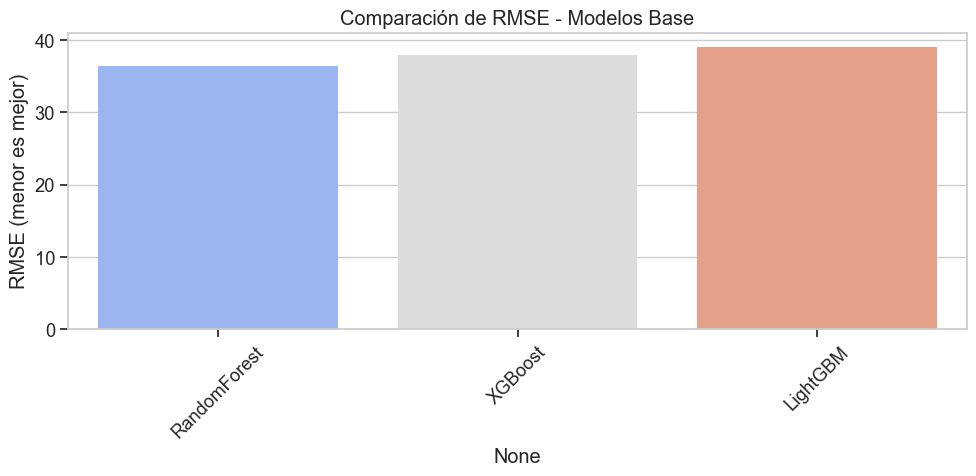

In [18]:
# 🔁 1. Importaciones necesarias
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from pathlib import Path

# ⚙️ 2. Diccionarios de almacenamiento
resultados_base = {}
modelos_base = {}
modelos_guardados = {}

# 📁 3. Rutas de modelos guardados
cnn_model_path = model_output_dir / 'cnn_model.h5'
convlstm_model_path = model_output_dir / 'convlstm_model.h5'

model_paths = {
    'RandomForest': model_output_dir / 'RandomForest.pkl',
    'XGBoost': model_output_dir / 'XGBoost.pkl',
    'LightGBM': model_output_dir / 'LightGBM.pkl',
    'CNN': cnn_model_path,
    'ConvLSTM': convlstm_model_path
}

# ✅ 4. Carga y evaluación de modelos
for model_name, model_path in model_paths.items():
    if model_path.exists():
        print(f"Modelo {model_name} encontrado en {model_path}. Cargando...")
        if model_name in ['RandomForest', 'XGBoost', 'LightGBM']:
            with open(model_path, 'rb') as f:
                modelo = pickle.load(f)
                modelos_base[model_name] = modelo
                y_pred = modelo.predict(X_test_scaled)
        elif model_name == 'CNN':
            cnn_model = tf.keras.models.load_model(model_path)
            print("✅ CNN cargado.")
            y_pred = cnn_model.predict(X_test_spatial).squeeze()
        elif model_name == 'ConvLSTM':
            convlstm_model = tf.keras.models.load_model(model_path)
            print("✅ ConvLSTM cargado.")
            y_pred = convlstm_model.predict(X_test_spatial).squeeze()

        # Evaluar métricas si hay predicción
        if 'y_pred' in locals():
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            resultados_base[model_name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
            print(f"✅ {model_name} evaluado: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")
            del y_pred

# 📊 5. Visualización de resultados
print("\n🔍 Comparación de modelos base sin optimización:")
temp_df = pd.DataFrame(resultados_base, index=['RMSE', 'MAE', 'R2']).T

# Mostrar tabla ordenada por RMSE
print("\nOrdenados por RMSE (menor es mejor):")
display(temp_df.sort_values('RMSE'))

# Gráfico de comparación de RMSE
plt.figure(figsize=(10, 5))
sns.barplot(x=temp_df.index, y=temp_df['RMSE'], palette='coolwarm')
plt.title('Comparación de RMSE - Modelos Base')
plt.ylabel('RMSE (menor es mejor)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(model_output_dir / 'baseline_rmse_comparison_full.png')
plt.show()


In [ ]:
# ✅ Versión corregida y funcional de la optimización adaptativa con Optuna
import os
import gc
import psutil
import warnings
import pickle
import optuna
import numpy as np
from pathlib import Path
from sqlalchemy.exc import OperationalError
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

resultados_base = {}
model_paths = {}  # Para guardar rutas de modelos optimizados

# Suprimir warnings de XGBoost innecesarios
def suppress_specific_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
    os.environ["XGBOOST_DISABLE_USE_LABEL_ENCODER"] = "1"

suppress_specific_warnings()

def validate_database_path(db_path):
    """Valida que la base de datos SQLite tenga permisos de escritura."""
    try:
        with open(db_path, 'a') as f:
            pass
        print(f"✅ Base de datos validada: {db_path}")
    except IOError as e:
        print(f"❌ Error de permisos en la base de datos: {db_path}. {e}")
        print("Usando base de datos en memoria como alternativa.")
        return ':memory:'
    return db_path

class OptimizationProgressCallback:
    def __init__(self, total_trials, model_name="Modelo"):
        self.total_trials = total_trials
        self.model_name = model_name

    def __call__(self, study, trial):
        completed_trials = len(study.trials)
        if completed_trials % 5 == 0 or completed_trials == self.total_trials:
            print(f"📈 [{self.model_name}] Trials completados: {completed_trials}/{self.total_trials}")

def run_memory_efficient_optimization(model_type, X_train, y_train, X_test, y_test):
    print(f"\n📊 Iniciando optimización adaptativa para {model_type}...")

    # Verificar si el modelo ya existe
    model_path = model_output_dir / f"{model_type}_optimized.pkl"
    if model_path.exists():
        print(f"✅ Modelo optimizado encontrado: {model_path}. Cargando...")
        with open(model_path, 'rb') as f:
            best_model = pickle.load(f)
        y_pred = best_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"\n✅ {model_type} cargado y evaluado:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R²: {r2:.4f}")
        resultados_base[f"{model_type}_Optuna"] = (rmse, mae, r2)
        model_paths[f"{model_type}_Optuna"] = model_path
        return None, best_model, (rmse, mae, r2)

    available_memory_gb = psutil.virtual_memory().available / (1024**3)
    print(f"Memoria RAM disponible: {available_memory_gb:.2f} GB")

    model_types = {
        'RandomForest': RandomForestRegressor,
        'XGBoost': XGBRegressor,
        'LightGBM': LGBMRegressor
    }

    if model_type not in model_types:
        raise ValueError(f"Tipo de modelo no soportado: {model_type}.")

    if available_memory_gb < 2.0:
        n_trials, max_estimators, max_depth, subsample = 10, 50, 6, 0.5
    elif available_memory_gb < 8.0:
        n_trials, max_estimators, max_depth, subsample = 30, 300, 12, 0.7
    else:
        n_trials, max_estimators, max_depth, subsample = 50, 500, 20, 0.9

    def objective(trial):
        common_params = {'random_state': 42}

        if model_type == 'RandomForest':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, max_estimators),
                'max_depth': trial.suggest_int('max_depth', 3, max_depth),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
                'n_jobs': -1
            }
        elif model_type == 'XGBoost':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, max_estimators),
                'max_depth': trial.suggest_int('max_depth', 3, max_depth),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, subsample),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'tree_method': 'hist',
                'n_jobs': -1,
                'verbosity': 0
            }
        elif model_type == 'LightGBM':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, max_estimators),
                'max_depth': trial.suggest_int('max_depth', 3, max_depth),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, subsample),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
                'boosting_type': 'gbdt',
                'n_jobs': -1,
                'verbose': -1
            }

        params.update(common_params)
        gc.collect()
        try:
            model = model_types[model_type](**params)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            return rmse
        except Exception as e:
            print(f"Error con parámetros: {params}\n{e}")
            return float('inf')

    db_path = validate_database_path(model_output_dir / f"{model_type}_study.db")

    try:
        study = optuna.create_study(
            study_name=f"{model_type}_memory_optimized",
            storage=f"sqlite:///{db_path}",
            direction='minimize',
            sampler=optuna.samplers.TPESampler(seed=42),
            pruner=optuna.pruners.MedianPruner(n_startup_trials=5),
            load_if_exists=True
        )
    except OperationalError as e:
        print(f"Error al acceder a la base de datos: {e}")
        print("Asegúrate de que la base de datos no sea de solo lectura o verifica los permisos.")
        return None, None, None

    study.optimize(objective, n_trials=n_trials, callbacks=[OptimizationProgressCallback(n_trials, model_type)])

    best_params = study.best_params
    best_params['random_state'] = 42
    if model_type == 'XGBoost':
        best_params['tree_method'] = 'hist'

    best_model = model_types[model_type](**best_params)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n✅ {model_type} optimizado:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    resultados_base[f"{model_type}_Optuna"] = (rmse, mae, r2)

    with open(model_path, 'wb') as f:
        pickle.dump(best_model, f)
    model_paths[f"{model_type}_Optuna"] = model_path

    return best_params, best_model, (rmse, mae, r2)

# ✅ Ejecutar optimización adaptativa para todos los modelos base
if 'X_train_scaled' in globals() and 'y_train' in globals() and 'X_test_scaled' in globals() and 'y_test' in globals():
    print("\n🚀 Ejecutando optimización para RandomForest...")
    rf_params, rf_model, rf_metrics = run_memory_efficient_optimization('RandomForest', X_train_scaled, y_train, X_test_scaled, y_test)

    print("\n🚀 Ejecutando optimización para XGBoost...")
    xgb_params, xgb_model, xgb_metrics = run_memory_efficient_optimization('XGBoost', X_train_scaled, y_train, X_test_scaled, y_test)

    print("\n🚀 Ejecutando optimización para LightGBM...")
    lgb_params, lgb_model, lgb_metrics = run_memory_efficient_optimization('LightGBM', X_train_scaled, y_train, X_test_scaled, y_test)

    # 📊 Comparación de métricas
    print("\n📊 Comparación de modelos optimizados:")
    print("Modelo\t\tRMSE\t\tMAE\t\tR2")
    print(f"RandomForest\t{rf_metrics[0]:.4f}\t{rf_metrics[1]:.4f}\t{rf_metrics[2]:.4f}")
    print(f"XGBoost    \t{xgb_metrics[0]:.4f}\t{xgb_metrics[1]:.4f}\t{xgb_metrics[2]:.4f}")
    print(f"LightGBM   \t{lgb_metrics[0]:.4f}\t{lgb_metrics[1]:.4f}\t{lgb_metrics[2]:.4f}")
else:
    print("❌ No se encontraron las variables X_train_scaled, y_train, X_test_scaled o y_test en el entorno actual.")

[I 2025-04-29 16:33:02,783] Using an existing study with name 'RandomForest_memory_optimized' instead of creating a new one.



🚀 Ejecutando optimización para RandomForest...

📊 Iniciando optimización adaptativa para RandomForest...
Memoria RAM disponible: 2.68 GB


[I 2025-04-29 16:34:17,036] Trial 71 finished with value: 43.0440408355221 and parameters: {'n_estimators': 236, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 41.650861342260036.
[I 2025-04-29 16:35:50,192] Trial 72 finished with value: 41.654383989762835 and parameters: {'n_estimators': 283, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 41.650861342260036.
[I 2025-04-29 16:35:50,192] Trial 72 finished with value: 41.654383989762835 and parameters: {'n_estimators': 283, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 41.650861342260036.
[I 2025-04-29 16:36:53,665] Trial 73 finished with value: 51.355881691959375 and parameters: {'n_estimators': 278, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_fe

📈 [RandomForest] Trials completados: 75/30


[I 2025-04-29 16:39:47,962] Trial 75 finished with value: 41.64772576154432 and parameters: {'n_estimators': 275, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 74 with value: 41.64597096124543.
[I 2025-04-29 16:41:15,145] Trial 76 finished with value: 41.691880166992064 and parameters: {'n_estimators': 286, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 74 with value: 41.64597096124543.
[I 2025-04-29 16:41:15,145] Trial 76 finished with value: 41.691880166992064 and parameters: {'n_estimators': 286, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 74 with value: 41.64597096124543.
[I 2025-04-29 16:42:31,968] Trial 77 finished with value: 43.00608196630091 and parameters: {'n_estimators': 265, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_f

📈 [RandomForest] Trials completados: 80/30


[I 2025-04-29 16:46:54,227] Trial 80 finished with value: 43.04835989883482 and parameters: {'n_estimators': 282, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 74 with value: 41.64597096124543.
[I 2025-04-29 16:48:19,357] Trial 81 finished with value: 41.69681251087568 and parameters: {'n_estimators': 270, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 74 with value: 41.64597096124543.
[I 2025-04-29 16:48:19,357] Trial 81 finished with value: 41.69681251087568 and parameters: {'n_estimators': 270, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 74 with value: 41.64597096124543.
[I 2025-04-29 16:49:30,819] Trial 82 finished with value: 43.030839861369635 and parameters: {'n_estimators': 250, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_fea

📈 [RandomForest] Trials completados: 85/30


[I 2025-04-29 16:53:36,052] Trial 85 finished with value: 41.630928646181296 and parameters: {'n_estimators': 265, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 85 with value: 41.630928646181296.
[I 2025-04-29 16:54:56,438] Trial 86 finished with value: 41.63236035252783 and parameters: {'n_estimators': 262, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 85 with value: 41.630928646181296.
[I 2025-04-29 16:54:56,438] Trial 86 finished with value: 41.63236035252783 and parameters: {'n_estimators': 262, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 85 with value: 41.630928646181296.
[I 2025-04-29 16:56:17,515] Trial 87 finished with value: 41.63168439572765 and parameters: {'n_estimators': 267, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max

📈 [RandomForest] Trials completados: 90/30


[I 2025-04-29 17:00:16,124] Trial 90 finished with value: 41.63819224368401 and parameters: {'n_estimators': 271, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 88 with value: 41.629667633906514.
[I 2025-04-29 17:01:52,929] Trial 91 finished with value: 43.02755147184142 and parameters: {'n_estimators': 265, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 88 with value: 41.629667633906514.
[I 2025-04-29 17:01:52,929] Trial 91 finished with value: 43.02755147184142 and parameters: {'n_estimators': 265, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 88 with value: 41.629667633906514.
[I 2025-04-29 17:03:13,422] Trial 92 finished with value: 41.670070498415335 and parameters: {'n_estimators': 269, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 8, 'm

📈 [RandomForest] Trials completados: 95/30


[I 2025-04-29 17:17:53,290] Trial 95 finished with value: 41.09841375209928 and parameters: {'n_estimators': 294, 'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 93 with value: 41.09717031410784.
[I 2025-04-29 17:22:27,136] Trial 96 finished with value: 42.666457847822166 and parameters: {'n_estimators': 288, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 93 with value: 41.09717031410784.
[I 2025-04-29 17:22:27,136] Trial 96 finished with value: 42.666457847822166 and parameters: {'n_estimators': 288, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 93 with value: 41.09717031410784.
[I 2025-04-29 17:27:18,780] Trial 97 finished with value: 41.09796048819834 and parameters: {'n_estimators': 293, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_feature

📈 [RandomForest] Trials completados: 100/30


[I 2025-04-29 17:41:09,715] Trial 100 finished with value: 41.10270157234539 and parameters: {'n_estimators': 282, 'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 93 with value: 41.09717031410784.
[I 2025-04-29 18:15:57,855] Using an existing study with name 'XGBoost_memory_optimized' instead of creating a new one.
[I 2025-04-29 18:15:57,855] Using an existing study with name 'XGBoost_memory_optimized' instead of creating a new one.



✅ RandomForest optimizado:
RMSE: 41.0972
MAE: 28.4235
R²: 0.8940

🚀 Ejecutando optimización para XGBoost...

📊 Iniciando optimización adaptativa para XGBoost...
Memoria RAM disponible: 2.98 GB


[I 2025-04-29 18:16:04,475] Trial 60 finished with value: 39.350894779177196 and parameters: {'n_estimators': 278, 'max_depth': 4, 'learning_rate': 0.09965645419053396, 'subsample': 0.6711679030463277, 'colsample_bytree': 0.9044181459811054, 'min_child_weight': 3, 'gamma': 2.4751802377230163}. Best is trial 22 with value: 35.711163960942415.
[I 2025-04-29 18:16:17,690] Trial 61 finished with value: 35.75791576754806 and parameters: {'n_estimators': 189, 'max_depth': 12, 'learning_rate': 0.05560460746814403, 'subsample': 0.6157528967223698, 'colsample_bytree': 0.9706361090180385, 'min_child_weight': 2, 'gamma': 4.795362732218826}. Best is trial 22 with value: 35.711163960942415.
[I 2025-04-29 18:16:17,690] Trial 61 finished with value: 35.75791576754806 and parameters: {'n_estimators': 189, 'max_depth': 12, 'learning_rate': 0.05560460746814403, 'subsample': 0.6157528967223698, 'colsample_bytree': 0.9706361090180385, 'min_child_weight': 2, 'gamma': 4.795362732218826}. Best is trial 22 wi

📈 [XGBoost] Trials completados: 65/30


[I 2025-04-29 18:17:12,363] Trial 65 finished with value: 35.93389418051657 and parameters: {'n_estimators': 246, 'max_depth': 11, 'learning_rate': 0.042380034888878704, 'subsample': 0.634546770187394, 'colsample_bytree': 0.9868323406552163, 'min_child_weight': 2, 'gamma': 3.529303523512869}. Best is trial 22 with value: 35.711163960942415.
[I 2025-04-29 18:17:27,468] Trial 66 finished with value: 35.7568318701563 and parameters: {'n_estimators': 233, 'max_depth': 12, 'learning_rate': 0.05218237651264639, 'subsample': 0.5661149485002318, 'colsample_bytree': 0.9439404052896394, 'min_child_weight': 4, 'gamma': 4.661850070951837}. Best is trial 22 with value: 35.711163960942415.
[I 2025-04-29 18:17:27,468] Trial 66 finished with value: 35.7568318701563 and parameters: {'n_estimators': 233, 'max_depth': 12, 'learning_rate': 0.05218237651264639, 'subsample': 0.5661149485002318, 'colsample_bytree': 0.9439404052896394, 'min_child_weight': 4, 'gamma': 4.661850070951837}. Best is trial 22 with 

📈 [XGBoost] Trials completados: 70/30


[I 2025-04-29 18:18:08,251] Trial 70 finished with value: 36.29877006191549 and parameters: {'n_estimators': 60, 'max_depth': 12, 'learning_rate': 0.07978866991243412, 'subsample': 0.6204252253199223, 'colsample_bytree': 0.9458081925372654, 'min_child_weight': 3, 'gamma': 4.230545493841141}. Best is trial 22 with value: 35.711163960942415.
[I 2025-04-29 18:18:25,009] Trial 71 finished with value: 35.74243083933558 and parameters: {'n_estimators': 237, 'max_depth': 12, 'learning_rate': 0.04515644294615783, 'subsample': 0.5798589296637613, 'colsample_bytree': 0.9285770570455675, 'min_child_weight': 10, 'gamma': 4.274402251955779}. Best is trial 22 with value: 35.711163960942415.
[I 2025-04-29 18:18:25,009] Trial 71 finished with value: 35.74243083933558 and parameters: {'n_estimators': 237, 'max_depth': 12, 'learning_rate': 0.04515644294615783, 'subsample': 0.5798589296637613, 'colsample_bytree': 0.9285770570455675, 'min_child_weight': 10, 'gamma': 4.274402251955779}. Best is trial 22 wi

📈 [XGBoost] Trials completados: 75/30


[I 2025-04-29 18:19:28,279] Trial 75 finished with value: 35.73431863517636 and parameters: {'n_estimators': 248, 'max_depth': 12, 'learning_rate': 0.03550587326367754, 'subsample': 0.5853810740267053, 'colsample_bytree': 0.9848024319125552, 'min_child_weight': 10, 'gamma': 3.2196387008894387}. Best is trial 22 with value: 35.711163960942415.
[I 2025-04-29 18:19:42,961] Trial 76 finished with value: 36.00257186179985 and parameters: {'n_estimators': 252, 'max_depth': 11, 'learning_rate': 0.034998807001642256, 'subsample': 0.5675217142538795, 'colsample_bytree': 0.9851899024509025, 'min_child_weight': 9, 'gamma': 3.093088683386659}. Best is trial 22 with value: 35.711163960942415.
[I 2025-04-29 18:19:42,961] Trial 76 finished with value: 36.00257186179985 and parameters: {'n_estimators': 252, 'max_depth': 11, 'learning_rate': 0.034998807001642256, 'subsample': 0.5675217142538795, 'colsample_bytree': 0.9851899024509025, 'min_child_weight': 9, 'gamma': 3.093088683386659}. Best is trial 22

📈 [XGBoost] Trials completados: 80/30


[I 2025-04-29 18:20:45,812] Trial 80 finished with value: 36.342193176565615 and parameters: {'n_estimators': 246, 'max_depth': 11, 'learning_rate': 0.0222884772088816, 'subsample': 0.6932643683811397, 'colsample_bytree': 0.9526654313936672, 'min_child_weight': 8, 'gamma': 3.6105962388974575}. Best is trial 22 with value: 35.711163960942415.
[I 2025-04-29 18:20:58,031] Trial 81 finished with value: 38.18438478240729 and parameters: {'n_estimators': 240, 'max_depth': 12, 'learning_rate': 0.2909337937359037, 'subsample': 0.5878028466351641, 'colsample_bytree': 0.9061703640467523, 'min_child_weight': 10, 'gamma': 3.0007930472949615}. Best is trial 22 with value: 35.711163960942415.
[I 2025-04-29 18:20:58,031] Trial 81 finished with value: 38.18438478240729 and parameters: {'n_estimators': 240, 'max_depth': 12, 'learning_rate': 0.2909337937359037, 'subsample': 0.5878028466351641, 'colsample_bytree': 0.9061703640467523, 'min_child_weight': 10, 'gamma': 3.0007930472949615}. Best is trial 22 

📈 [XGBoost] Trials completados: 85/30


[I 2025-04-29 18:22:05,241] Trial 85 finished with value: 35.65736947738679 and parameters: {'n_estimators': 278, 'max_depth': 12, 'learning_rate': 0.039820465006311104, 'subsample': 0.6851098826016436, 'colsample_bytree': 0.9806212460161695, 'min_child_weight': 9, 'gamma': 2.396802314871436}. Best is trial 85 with value: 35.65736947738679.
[I 2025-04-29 18:22:20,476] Trial 86 finished with value: 35.848257059161014 and parameters: {'n_estimators': 284, 'max_depth': 11, 'learning_rate': 0.05007009745059281, 'subsample': 0.6834848267189058, 'colsample_bytree': 0.9565882330975652, 'min_child_weight': 9, 'gamma': 2.058496403793079}. Best is trial 85 with value: 35.65736947738679.
[I 2025-04-29 18:22:20,476] Trial 86 finished with value: 35.848257059161014 and parameters: {'n_estimators': 284, 'max_depth': 11, 'learning_rate': 0.05007009745059281, 'subsample': 0.6834848267189058, 'colsample_bytree': 0.9565882330975652, 'min_child_weight': 9, 'gamma': 2.058496403793079}. Best is trial 85 wi

📈 [XGBoost] Trials completados: 90/30

✅ XGBoost optimizado:
RMSE: 35.6574
MAE: 24.4894
R²: 0.9202

✅ XGBoost optimizado:
RMSE: 35.6574
MAE: 24.4894
R²: 0.9202


[I 2025-04-29 18:23:26,252] Using an existing study with name 'LightGBM_memory_optimized' instead of creating a new one.



🚀 Ejecutando optimización para LightGBM...

📊 Iniciando optimización adaptativa para LightGBM...
Memoria RAM disponible: 2.53 GB


/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-29 18:23:35,991] Trial 30 finished with value: 39.346963352381465 and parameters: {'n_estimators': 264, 'max_depth': 11, 'learning_rate': 0.030730292125606733, 'subsample': 0.6388874218385346, 'colsample_bytree': 0.7249078901559086, 'min_child_samples': 75, 'reg_alpha': 0.5606647973347033, 'reg_lambda': 0.31039256966243556}. Best is trial 28 with value: 37.34593941374425.
[I 2025-04-29 18:23:35,991] Trial 30 finished with value: 39.346963352381465 and parameters: {'n_estimators': 264, 'max_depth': 11, 'learning_rate': 0.030730292125606733, 'subsample': 0.6388874218385346, 'colsample_bytree': 0.7249078901559086, 'min_child_samples': 75, 'reg_alpha': 0.5606647973347033, 'reg_lambda': 0.31039256966243556}. Best is trial 28 with value: 37.34593

📈 [LightGBM] Trials completados: 35/30


/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-29 18:23:58,440] Trial 35 finished with value: 37.71705705316589 and parameters: {'n_estimators': 237, 'max_depth': 10, 'learning_rate': 0.18188215906458088, 'subsample': 0.5965280731754736, 'colsample_bytree': 0.7304453570550351, 'min_child_samples': 96, 'reg_alpha': 0.5795660494660648, 'reg_lambda': 0.06150172334536236}. Best is trial 28 with value: 37.34593941374425.
[I 2025-04-29 18:23:58,440] Trial 35 finished with value: 37.71705705316589 and parameters: {'n_estimators': 237, 'max_depth': 10, 'learning_rate': 0.18188215906458088, 'subsample': 0.5965280731754736, 'colsample_bytree': 0.7304453570550351, 'min_child_samples': 96, 'reg_alpha': 0.5795660494660648, 'reg_lambda': 0.06150172334536236}. Best is trial 28 with value: 37.345939413

📈 [LightGBM] Trials completados: 40/30


/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-29 18:24:22,769] Trial 40 finished with value: 37.406313496849414 and parameters: {'n_estimators': 212, 'max_depth': 11, 'learning_rate': 0.2564730232409371, 'subsample': 0.5827193516669354, 'colsample_bytree': 0.9956385980717999, 'min_child_samples': 94, 'reg_alpha': 0.8561476253366959, 'reg_lambda': 0.6195514196763037}. Best is trial 28 with value: 37.34593941374425.
[I 2025-04-29 18:24:22,769] Trial 40 finished with value: 37.406313496849414 and parameters: {'n_estimators': 212, 'max_depth': 11, 'learning_rate': 0.2564730232409371, 'subsample': 0.5827193516669354, 'colsample_bytree': 0.9956385980717999, 'min_child_samples': 94, 'reg_alpha': 0.8561476253366959, 'reg_lambda': 0.6195514196763037}. Best is trial 28 with value: 37.34593941374

📈 [LightGBM] Trials completados: 45/30


/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-29 18:24:44,321] Trial 45 finished with value: 37.72344154662176 and parameters: {'n_estimators': 155, 'max_depth': 12, 'learning_rate': 0.2530776546075986, 'subsample': 0.5595842637629191, 'colsample_bytree': 0.9895543668226564, 'min_child_samples': 96, 'reg_alpha': 0.876341014048042, 'reg_lambda': 0.8899315843787003}. Best is trial 28 with value: 37.34593941374425.
[I 2025-04-29 18:24:44,321] Trial 45 finished with value: 37.72344154662176 and parameters: {'n_estimators': 155, 'max_depth': 12, 'learning_rate': 0.2530776546075986, 'subsample': 0.5595842637629191, 'colsample_bytree': 0.9895543668226564, 'min_child_samples': 96, 'reg_alpha': 0.876341014048042, 'reg_lambda': 0.8899315843787003}. Best is trial 28 with value: 37.34593941374425.

📈 [LightGBM] Trials completados: 50/30


/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-29 18:25:16,729] Trial 50 finished with value: 37.82833306131848 and parameters: {'n_estimators': 275, 'max_depth': 11, 'learning_rate': 0.09786691390401238, 'subsample': 0.6485689141374892, 'colsample_bytree': 0.8940592932171196, 'min_child_samples': 26, 'reg_alpha': 0.8116885110866364, 'reg_lambda': 0.46400922155888225}. Best is trial 48 with value: 37.11077711702346.
[I 2025-04-29 18:25:16,729] Trial 50 finished with value: 37.82833306131848 and parameters: {'n_estimators': 275, 'max_depth': 11, 'learning_rate': 0.09786691390401238, 'subsample': 0.6485689141374892, 'colsample_bytree': 0.8940592932171196, 'min_child_samples': 26, 'reg_alpha': 0.8116885110866364, 'reg_lambda': 0.46400922155888225}. Best is trial 48 with value: 37.110777117

📈 [LightGBM] Trials completados: 55/30


/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-29 18:25:42,599] Trial 55 finished with value: 37.385937843327525 and parameters: {'n_estimators': 283, 'max_depth': 11, 'learning_rate': 0.1588812395864361, 'subsample': 0.6998177129720142, 'colsample_bytree': 0.9760117343443714, 'min_child_samples': 86, 'reg_alpha': 0.8338821359211896, 'reg_lambda': 0.7384309113212614}. Best is trial 48 with value: 37.11077711702346.
[I 2025-04-29 18:25:42,599] Trial 55 finished with value: 37.385937843327525 and parameters: {'n_estimators': 283, 'max_depth': 11, 'learning_rate': 0.1588812395864361, 'subsample': 0.6998177129720142, 'colsample_bytree': 0.9760117343443714, 'min_child_samples': 86, 'reg_alpha': 0.8338821359211896, 'reg_lambda': 0.7384309113212614}. Best is trial 48 with value: 37.11077711702

📈 [LightGBM] Trials completados: 60/30


/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



✅ LightGBM optimizado:
RMSE: 37.1108
MAE: 25.8193
R²: 0.9136

📊 Comparación de modelos optimizados:
Modelo		RMSE		MAE		R2
RandomForest	41.0972	28.4235	0.8940
XGBoost    	35.6574	24.4894	0.9202
LightGBM   	37.1108	25.8193	0.9136


: 

## 🧠 Implementación de Modelos de Deep Learning

A continuación implementaremos modelos basados en redes neuronales profundas para capturar patrones espaciales y temporales en los datos de precipitación.

In [ ]:
# Implementación de modelo CNN para predicción espacial
import gc  # Para liberar memoria

print("\n🔍 Preparando datos para modelos CNN...")

# Verificar si tenemos columnas de coordenadas en nuestros datos
coord_cols = [col for col in feature_cols if col in ['x', 'y', 'latitude', 'longitude', 'lat', 'lon']]

if len(coord_cols) >= 2:
    print(f"Columnas de coordenadas encontradas: {coord_cols}")
    
    # Mapeo de nombres de columnas comunes
    lat_names = ['latitude', 'lat', 'y']
    lon_names = ['longitude', 'lon', 'x']
    
    # Identificar columnas de latitud y longitud
    lat_col = next((col for col in coord_cols if col in lat_names), None)
    lon_col = next((col for col in coord_cols if col in lon_names), None)
    
    if lat_col and lon_col:
        print(f"Usando {lat_col} y {lon_col} como coordenadas para CNN")
        
        # Convertir datos a formato espacial para CNN
        def prepare_spatial_data(X_data, y_data, lat_col, lon_col):
            """Prepara datos espaciales para CNN"""
            try:
                # Extraer coordenadas únicas en orden
                lats = sorted(X_data[lat_col].unique())
                lons = sorted(X_data[lon_col].unique())
                
                # Crear diccionarios de mapeo para índices
                lat_to_idx = {lat: idx for idx, lat in enumerate(lats)}
                lon_to_idx = {lon: idx for idx, lon in enumerate(lons)}
                
                # Dimensiones de la grilla
                grid_height = len(lats)
                grid_width = len(lons)
                n_features = X_data.shape[1] - 2  # Restar las dos columnas de coordenadas
                
                # Inicializar arrays
                X_grid = np.zeros((len(X_data), grid_height, grid_width, n_features), dtype=np.float32)
                y_grid = np.zeros((len(y_data), grid_height, grid_width, 1), dtype=np.float32)
                
                # Recorrer todos los datos y ubicarlos en la grilla
                non_coord_cols = [col for col in X_data.columns if col != lat_col and col != lon_col]
                
                for idx in range(len(X_data)):
                    lat = X_data.iloc[idx][lat_col]
                    lon = X_data.iloc[idx][lon_col]
                    
                    lat_idx = lat_to_idx[lat]
                    lon_idx = lon_to_idx[lon]
                    
                    # Colocar características en la grilla
                    for i, col in enumerate(non_coord_cols):
                        X_grid[idx, lat_idx, lon_idx, i] = X_data.iloc[idx][col]
                    
                    # Colocar valor objetivo
                    y_grid[idx, lat_idx, lon_idx, 0] = y_data.iloc[idx]
                
                return X_grid, y_grid
            except Exception as e:
                print(f"Error preparando datos espaciales: {e}")
                return None, None
        
        # Convertir datos de entrenamiento a formato espacial
        print("Convirtiendo datos a formato espacial...")
        try:
            X_train_df = pd.DataFrame(X_train_scaled, columns=feature_cols)
            X_test_df = pd.DataFrame(X_test_scaled, columns=feature_cols)
            
            X_train_spatial, y_train_spatial = prepare_spatial_data(X_train_df, y_train, lat_col, lon_col)
            X_test_spatial, y_test_spatial = prepare_spatial_data(X_test_df, y_test, lat_col, lon_col)
            
            if X_train_spatial is None or X_test_spatial is None:
                raise ValueError("Error al preparar datos espaciales para CNN.")
            
            print(f"Datos espaciales preparados:")
            print(f"X_train_spatial: {X_train_spatial.shape}")
            print(f"y_train_spatial: {y_train_spatial.shape}")
            print(f"X_test_spatial: {X_test_spatial.shape}")
            print(f"y_test_spatial: {y_test_spatial.shape}")
            
            # Liberar memoria innecesaria
            del X_train_df, X_test_df
            gc.collect()
            
            # Modelo CNN para predicción de precipitación
            def create_cnn_model(input_shape):
                """Crea un modelo CNN para predicción espacial"""
                inputs = Input(shape=input_shape)
                x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
                x = BatchNormalization()(x)
                x = MaxPooling2D(pool_size=(2, 2))(x)
                x = Dropout(0.25)(x)
                x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
                x = BatchNormalization()(x)
                x = MaxPooling2D(pool_size=(2, 2))(x)
                x = Dropout(0.25)(x)
                outputs = Conv2D(1, kernel_size=(1, 1), activation='linear', padding='same')(x)
                model = Model(inputs=inputs, outputs=outputs)
                model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])
                return model
            
            print("\n🧠 Creando y entrenando modelo CNN...")
            input_shape = X_train_spatial.shape[1:]
            cnn_model = create_cnn_model(input_shape)
            cnn_model.summary()
            
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
                ModelCheckpoint(filepath=model_output_dir / 'cnn_model_best.h5', save_best_only=True, monitor='val_loss')
            ]
            
            history = cnn_model.fit(
                X_train_spatial, y_train_spatial,
                validation_split=0.2,
                epochs=100,
                batch_size=32,
                callbacks=callbacks,
                verbose=1
            )
            
            print("\n📊 Evaluando modelo CNN...")
            cnn_metrics = cnn_model.evaluate(X_test_spatial, y_test_spatial)
            print(f"Loss (MSE): {cnn_metrics[0]:.4f}")
            print(f"MAE: {cnn_metrics[1]:.4f}")
            
            cnn_model.save(model_output_dir / 'cnn_model_final.h5')
            print("Modelo CNN guardado correctamente.")
            
        except Exception as e:
            print(f"Error preparando datos espaciales para CNN: {e}")
    else:
        print("No se pudieron identificar columnas de latitud y longitud.")
else:
    print("No se encontraron suficientes columnas de coordenadas para implementar CNN.")


🔍 Preparando datos para modelos CNN...
Columnas de coordenadas encontradas: ['latitude', 'longitude']
Usando latitude y longitude como coordenadas para CNN
Convirtiendo datos a formato espacial...


In [ ]:
# Implementación de modelo ConvLSTM para predicción espaciotemporal
print("\n🔍 Preparando datos para modelo ConvLSTM...")

# Verificar si tenemos el DataFrame disponible
if 'df' not in locals() or df is None:
    print("DataFrame no disponible, intentando recargarlo...")
    try:
        # Recargar el dataset si no está disponible
        data_file = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features.nc'
        print(f"Recargando archivo desde: {data_file}")
        df, ds_original = load_dataset(data_file)
        
        if df is None:
            print("Error: No se pudo recargar el DataFrame. Verificar la ruta del archivo.")
    except Exception as e:
        print(f"Error al recargar el DataFrame: {e}")
        import traceback
        traceback.print_exc()

# Verificar si tenemos las variables necesarias
if 'feature_cols' not in locals() or 'target_column' not in locals():
    print("Variables necesarias no definidas, intentando redefinirlas...")
    if df is not None:
        # Identificar la columna objetivo (precipitación)
        target_column = 'total_precipitation'  # Ajustar si tiene otro nombre en tu dataset
        
        # Ver si existe 'precip_target' o usar 'total_precipitation'
        if 'total_precipitation' in df.columns:
            target_column = 'total_precipitation'
        
        # Separar variables predictoras y variable objetivo
        feature_cols = [col for col in df.columns if col != target_column and not pd.isna(df[col]).all()]
        
        # Eliminar columnas no numéricas para los modelos
        non_feature_cols = ['time', 'spatial_ref']
        feature_cols = [col for col in feature_cols if col not in non_feature_cols]

# Si el DataFrame está disponible, continuar con la preparación de datos
if df is not None:
    # Para ConvLSTM necesitamos datos con dimensión temporal
    time_cols = [col for col in df.columns if col in ['time', 'date', 'month', 'year', 'day']]

    if len(time_cols) > 0 and len(coord_cols) >= 2:
        print(f"Columnas temporales encontradas: {time_cols}")
        time_col = time_cols[0]
        
        # Función para preparar datos espaciotemporales
        def prepare_spatiotemporal_data(df, feature_cols, target_column, lat_col, lon_col, time_col, 
                                        sequence_length=3):
            """Prepara datos para ConvLSTM con dimensión espaciotemporal"""
            print("Preparando datos espaciotemporales para ConvLSTM...")
            try:
                # Asegurarnos que la columna temporal está ordenada
                # Verificar el tipo de la columna temporal
                time_dtype = df[time_col].dtype
                print(f"Tipo de dato de columna temporal: {time_dtype}")
                
                if pd.api.types.is_datetime64_any_dtype(df[time_col]):
                    # Ya es datetime, ordenamos
                    df_sorted = df.sort_values(by=time_col)
                else:
                    # Intentar convertir a datetime
                    try:
                        df[time_col] = pd.to_datetime(df[time_col])
                        df_sorted = df.sort_values(by=time_col)
                    except Exception as e:
                        print(f"No se pudo convertir columna temporal a datetime: {e}")
                        # Si no podemos convertir, asumimos que ya está ordenado
                        df_sorted = df
                
                # Extraer coordenadas únicas
                lats = sorted(df_sorted[lat_col].unique())
                lons = sorted(df_sorted[lon_col].unique())
                time_steps = sorted(df_sorted[time_col].unique())
                
                print(f"Dimensiones espaciotemporales:")
                print(f"- Latitudes (filas): {len(lats)}")
                print(f"- Longitudes (columnas): {len(lons)}")
                print(f"- Pasos temporales: {len(time_steps)}")
                
                # Crear mapeos para índices
                lat_to_idx = {lat: idx for idx, lat in enumerate(lats)}
                lon_to_idx = {lon: idx for idx, lon in enumerate(lons)}
                time_to_idx = {time: idx for idx, time in enumerate(time_steps)}
                
                # Filtrar columnas feature eliminando coordenadas y tiempo
                feature_cols_filtered = [col for col in feature_cols if col != lat_col and col != lon_col and col != time_col]
                n_features = len(feature_cols_filtered)
                
                # Dimensiones de la grilla espaciotemporal
                grid_height = len(lats)
                grid_width = len(lons)
                n_timesteps = len(time_steps)
                
                print(f"Características a usar: {n_features}")
                
                # Crear un DataFrame indexado para acceso rápido
                df_indexed = df_sorted.set_index([time_col, lat_col, lon_col])
                
                # Crear matrices 3D para cada paso temporal
                # Las dimensiones son: [tiempo, altura, ancho, features]
                X_spatiotemporal = np.zeros((n_timesteps, grid_height, grid_width, n_features))
                y_spatiotemporal = np.zeros((n_timesteps, grid_height, grid_width, 1))
                
                # Llenar matrices con datos disponibles
                for t_idx, t in enumerate(time_steps):
                    for lat_idx, lat in enumerate(lats):
                        for lon_idx, lon in enumerate(lons):
                            try:
                                # Obtener datos para esta coordenada y tiempo
                                data = df_indexed.loc[(t, lat, lon)]
                                
                                # Llenar características
                                for f_idx, feat in enumerate(feature_cols_filtered):
                                    X_spatiotemporal[t_idx, lat_idx, lon_idx, f_idx] = data[feat]
                                
                                # Llenar target
                                y_spatiotemporal[t_idx, lat_idx, lon_idx, 0] = data[target_column]
                            except KeyError:
                                # Este punto espaciotemporal no existe en los datos
                                pass
                
                # Crear secuencias para ConvLSTM
                # Para cada paso temporal t, usaremos t-sequence_length hasta t-1 para predecir t
                n_sequences = n_timesteps - sequence_length
                
                if n_sequences <= 0:
                    print("No hay suficientes pasos temporales para crear secuencias. Ajustando sequence_length.")
                    sequence_length = max(1, n_timesteps // 2)
                    n_sequences = n_timesteps - sequence_length
                    print(f"Nuevo sequence_length: {sequence_length}, n_sequences: {n_sequences}")
                
                # Crear arrays para secuencias
                X_sequences = np.zeros((n_sequences, sequence_length, grid_height, grid_width, n_features))
                y_sequences = np.zeros((n_sequences, grid_height, grid_width, 1))
                
                for i in range(n_sequences):
                    X_sequences[i] = X_spatiotemporal[i:i+sequence_length]
                    y_sequences[i] = y_spatiotemporal[i+sequence_length]
                
                print(f"Secuencias creadas:")
                print(f"X_sequences: {X_sequences.shape}")
                print(f"y_sequences: {y_sequences.shape}")
                
                # Dividir en train/test
                train_size = int(0.8 * n_sequences)
                X_train = X_sequences[:train_size]
                y_train = y_sequences[:train_size]
                X_test = X_sequences[train_size:]
                y_test = y_sequences[train_size:]
                
                return X_train, y_train, X_test, y_test
            except Exception as e:
                print(f"Error preparando datos espaciotemporales: {e}")
                import traceback
                traceback.print_exc()
                return None, None, None, None
        
        # Intentar preparar datos espaciotemporales
        try:
            X_train_convlstm, y_train_convlstm, X_test_convlstm, y_test_convlstm = prepare_spatiotemporal_data(
                df, feature_cols, target_column, lat_col, lon_col, time_col, sequence_length=3
            )
            
            # Si los datos se preparan correctamente, crear y entrenar modelo ConvLSTM
            if X_train_convlstm is not None:
                print("\n🧠 Creando y entrenando modelo ConvLSTM...")
                
                def create_convlstm_model(input_shape):
                    """Crea un modelo ConvLSTM para predicción espaciotemporal"""
                    model = Sequential([
                        # Capa ConvLSTM
                        ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same',
                                  return_sequences=True, activation='tanh',
                                  input_shape=input_shape),
                        BatchNormalization(),
                        
                        # Segunda capa ConvLSTM
                        ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same',
                                   return_sequences=False, activation='tanh'),
                        BatchNormalization(),
                        
                        # Capa convolucional para reducir mapas de características
                        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
                        BatchNormalization(),
                        MaxPooling2D(pool_size=(2, 2)),
                        
                        # Capas finales
                        Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
                        UpSampling2D(size=(2, 2)),  # Restaurar dimensión original
                        Conv2D(filters=1, kernel_size=(3, 3), activation='linear', padding='same')
                    ])
                    
                    # Compilar modelo
                    model.compile(
                        loss='mse',
                        optimizer=Adam(learning_rate=0.001),
                        metrics=['mae']
                    )
                    
                    return model
                
                # Crear modelo ConvLSTM
                input_shape = X_train_convlstm.shape[1:]  # (sequence_length, height, width, features)
                convlstm_model = create_convlstm_model(input_shape)
                
                # Mostrar resumen del modelo
                convlstm_model.summary()
                
                # Callbacks para entrenamiento
                callbacks = [
                    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                    ModelCheckpoint(filepath=model_output_dir / 'convlstm_model_best.h5',
                                  save_best_only=True, monitor='val_loss')
                ]
                
                # Entrenar modelo
                history = convlstm_model.fit(
                    X_train_convlstm, y_train_convlstm,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=16,
                    callbacks=callbacks,
                    verbose=1
                )
                
                # Evaluar modelo
                print("\n📊 Evaluando modelo ConvLSTM...")
                convlstm_metrics = convlstm_model.evaluate(X_test_convlstm, y_test_convlstm)
                print(f"Loss (MSE): {convlstm_metrics[0]:.4f}")
                print(f"MAE: {convlstm_metrics[1]:.4f}")
                
                # Predecir con el modelo
                y_pred_convlstm = convlstm_model.predict(X_test_convlstm)
                
                # Aplanar las predicciones para calcular métricas
                y_test_flat = y_test_convlstm.flatten()
                y_pred_flat = y_pred_convlstm.flatten()
                
                # Filtrar valores donde y_test_flat > 0 (presumiblemente donde hay datos)
                valid_indices = y_test_flat > 0
                y_test_valid = y_test_flat[valid_indices]
                y_pred_valid = y_pred_flat[valid_indices]
                
                # Calcular métricas
                convlstm_rmse = np.sqrt(mean_squared_error(y_test_valid, y_pred_valid))
                convlstm_mae = mean_absolute_error(y_test_valid, y_pred_valid)
                convlstm_r2 = r2_score(y_test_valid, y_pred_valid)
                
                print(f"RMSE: {convlstm_rmse:.4f}")
                print(f"MAE: {convlstm_mae:.4f}")
                print(f"R²: {convlstm_r2:.4f}")
                
                # Guardar modelo
                convlstm_model.save(model_output_dir / 'convlstm_model_final.h5')
                print("Modelo ConvLSTM guardado como 'convlstm_model_final.h5'")
                
                # Visualizar la historia del entrenamiento
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('Pérdida del modelo ConvLSTM')
                plt.ylabel('Pérdida')
                plt.xlabel('Época')
                plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
                
                plt.subplot(1, 2, 2)
                plt.plot(history.history['mae'])
                plt.plot(history.history['val_mae'])
                plt.title('Error absoluto medio ConvLSTM')
                plt.ylabel('MAE')
                plt.xlabel('Época')
                plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
                
                plt.tight_layout()
                plt.savefig(model_output_dir / 'convlstm_training_history.png')
                plt.show()
                
                # Añadir resultados a nuestro diccionario de comparación
                resultados_base['ConvLSTM'] = (convlstm_rmse, convlstm_mae, convlstm_r2)
            else:
                print("No se pudieron preparar datos para ConvLSTM.")
        except Exception as e:
            print(f"Error al ejecutar preparación de datos para ConvLSTM: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("No se encontraron columnas temporales o espaciales suficientes para implementar ConvLSTM.")
        print("El modelo ConvLSTM requiere al menos una columna temporal y dos columnas espaciales.")

In [ ]:
# Ejecutar optimización adaptativa de memoria RAM para modelos base
print("\n🔍 Ejecutando optimización adaptativa de memoria RAM para Random Forest...")
rf_params, rf_model_opt, rf_metrics_opt = run_memory_efficient_optimization('RandomForest', X_train_scaled, y_train, X_test_scaled, y_test)

print("\n🔍 Ejecutando optimización adaptativa de memoria RAM para XGBoost...")
xgb_params, xgb_model_opt, xgb_metrics_opt = run_memory_efficient_optimization('XGBoost', X_train_scaled, y_train, X_test_scaled, y_test)

print("\n🔍 Ejecutando optimización adaptativa de memoria RAM para LightGBM...")
lgbm_params, lgbm_model_opt, lgbm_metrics_opt = run_memory_efficient_optimization('LightGBM', X_train_scaled, y_train, X_test_scaled, y_test)

# Resumen de parámetros óptimos encontrados
print("\n📊 Mejores parámetros encontrados para cada modelo:")
print(f"\nRandom Forest: {rf_params}")
print(f"\nXGBoost: {xgb_params}")
print(f"\nLightGBM: {lgbm_params}")

In [ ]:
# Mejora de visibilidad en el entrenamiento y errores para modelos CNN y ConvLSTM
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def plot_training_history(history, model_name):
    """Visualiza la historia del entrenamiento de un modelo."""
    plt.figure(figsize=(12, 5))

    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title(f'Pérdida del modelo {model_name}')
    plt.ylabel('Pérdida')
    plt.xlabel('Época')
    plt.legend(loc='upper right')

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Entrenamiento')
    plt.plot(history.history['val_mae'], label='Validación')
    plt.title(f'Error absoluto medio (MAE) - {model_name}')
    plt.ylabel('MAE')
    plt.xlabel('Época')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

def display_model_metrics(metrics, model_name):
    """Muestra las métricas de evaluación de un modelo de forma visual."""
    rmse, mae, r2 = metrics
    display(HTML(f'<div style="background-color:#f5f5dc; padding:10px; border-radius:5px; margin-top:10px;">' +
                 f'<h3>📊 Métricas para {model_name}</h3>' +
                 f'<table style="width:100%; text-align:left;">' +
                 f'<tr><th>Métrica</th><th>Valor</th></tr>' +
                 f'<tr><td>RMSE</td><td>{rmse:.4f}</td></tr>' +
                 f'<tr><td>MAE</td><td>{mae:.4f}</td></tr>' +
                 f'<tr><td>R²</td><td>{r2:.4f}</td></tr>' +
                 f'</table></div>'))

# Aplicar mejoras de visibilidad al modelo CNN
if 'cnn_model' in locals() and 'history' in locals():
    print("\n📈 Visualizando historia del entrenamiento para modelo CNN...")
    plot_training_history(history, 'CNN')

if 'cnn_metrics' in locals():
    print("\n📊 Mostrando métricas para modelo CNN...")
    display_model_metrics((cnn_rmse, cnn_mae, cnn_r2), 'CNN')

# Aplicar mejoras de visibilidad al modelo ConvLSTM
if 'convlstm_model' in locals() and 'history' in locals():
    print("\n📈 Visualizando historia del entrenamiento para modelo ConvLSTM...")
    plot_training_history(history, 'ConvLSTM')

if 'convlstm_metrics' in locals():
    print("\n📊 Mostrando métricas para modelo ConvLSTM...")
    display_model_metrics((convlstm_rmse, convlstm_mae, convlstm_r2), 'ConvLSTM')